In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,KFold,RandomizedSearchCV
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
import warnings
import os
warnings.filterwarnings("ignore")


BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20


In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
class_names
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

Found 2152 files belonging to 3 classes.
(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [16]:
len(dataset)
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
len(train_ds)
test_ds = dataset.skip(54)
len(test_ds)
val_size=0.1
len(dataset)*val_size
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf_new(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf_new(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we will be resizing it to the desired size. 
Moreover, to improve model performance, we normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This happens while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [19]:
resize_and_rescale_new = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data and to avoid overfitting, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])



#### Applying Data Augmentation to Train Dataset

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Building Model

In [22]:

n_classes = 3
def model(input_shape):
    model = models.Sequential([
        resize_and_rescale_new,
        data_augmentation,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    
    model.build(input_shape=input_shape)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

In [23]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
#Initialize StratifiedKFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Extract labels using the map function
labels = np.concatenate([y for _, y in dataset], axis=0)
all_histories=[]
# Iterate through the folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"Fold {fold + 1}")

    # Create and compile the model
    model_instance = model(input_shape)
    for image_batch, labels_batch in train_ds.take(1):
        print("Input Shape before Resizing:", image_batch.shape)
    # Create datasets for this fold
    # train_ds = dataset.unbatch().skip(val_indices[-1]).batch(BATCH_SIZE)
    # val_ds = dataset.unbatch().batch(BATCH_SIZE).skip(train_indices[-1])
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
    )
    history = model_instance.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        verbose=1,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping]
    )
    all_histories.append(history)



Fold 1
Input Shape before Resizing: (32, 256, 256, 3)
Epoch 1/20
54/54 [==============================] - 80s 1s/step - loss: 0.8714 - accuracy: 0.5110 - val_loss: 0.8408 - val_accuracy: 0.6406
Epoch 2/20
54/54 [==============================] - 78s 1s/step - loss: 0.6153 - accuracy: 0.7448 - val_loss: 0.5348 - val_accuracy: 0.7760
Epoch 3/20
54/54 [==============================] - 78s 1s/step - loss: 0.4273 - accuracy: 0.8293 - val_loss: 0.4923 - val_accuracy: 0.7656
Epoch 4/20
54/54 [==============================] - 78s 1s/step - loss: 0.4928 - accuracy: 0.8044 - val_loss: 0.6448 - val_accuracy: 0.7448
Epoch 5/20
54/54 [==============================] - 76s 1s/step - loss: 0.2535 - accuracy: 0.9034 - val_loss: 0.2986 - val_accuracy: 0.8542
Epoch 6/20
54/54 [==============================] - 77s 1s/step - loss: 0.3021 - accuracy: 0.9115 - val_loss: 0.5479 - val_accuracy: 0.7240
Epoch 7/20
54/54 [==============================] - 76s 1s/step - loss: 0.7416 - accuracy: 0.6736 - val_lo

In [25]:
scores = model_instance.evaluate(test_ds)
print(f"Test Loss and Accuracy with modified model: {scores}")


8/8 [==============================] - 4s 191ms/step - loss: 0.1529 - accuracy: 0.9453
Test Loss and Accuracy with modified model: [0.15292838215827942, 0.9453125]


8/8 [==============================] - 5s 397ms/step
Confusion Matrix:
[[46 57  7]
 [53 67  8]
 [11  4  3]]

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.42      0.42      0.42       110
 Potato___Late_blight       0.52      0.52      0.52       128
     Potato___healthy       0.17      0.17      0.17        18

             accuracy                           0.45       256
            macro avg       0.37      0.37      0.37       256
         weighted avg       0.45      0.45      0.45       256



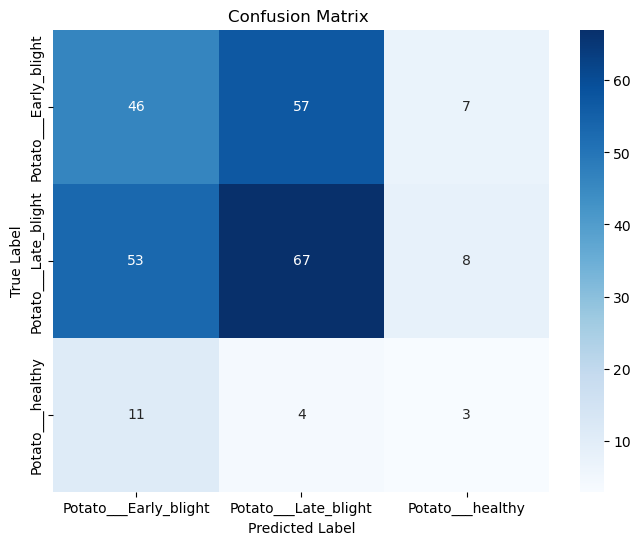

In [26]:
import seaborn as sns
predictions = model_instance.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)



# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display the classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Visualize the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 129ms/step


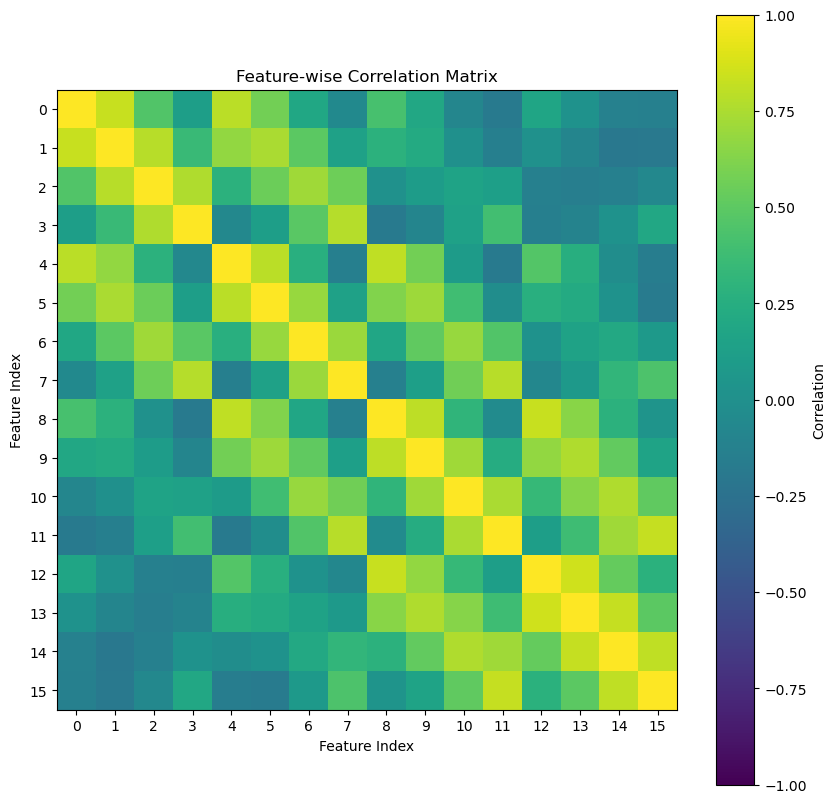

In [27]:
from tensorflow.keras.models import Model
# Find the last convolutional layer in  model
last_conv_layer_name = ""
for layer in model_instance.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break

# Function to generate the heatmap
def generate_heatmap(model, img_array, last_conv_layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to [0, 1]

    # Create a model that maps the input image to the activations of the last convolutional layer
    activation_model = Model(inputs=model.input, outputs=model.get_layer(last_conv_layer_name).output)

    # Get the activations of the last convolutional layer
    activations = activation_model.predict(img_array)

    # Take the mean of the activations to create a single channel heatmap
    heatmap = np.mean(activations, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap.flatten()  # Flatten the feature vector

# Directory path to your image dataset
dataset_path = 'PlantVillage'

# Initialize arrays to store feature vectors
feature_vectors = []

# Iterate through all images in the dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Load the original image and convert it to a numpy array
        img = np.array(image.load_img(image_path, target_size=(256, 256)))

        # Convert the image to a numpy array
        img_array = image.img_to_array(img)

        # Generate the heatmap using the last convolutional layer and flatten the feature vector
        feature_vector = generate_heatmap(model_instance, img_array, last_conv_layer_name)

        # Append the feature vector to the list
        feature_vectors.append(feature_vector)

# Convert the list of feature vectors to a numpy array
feature_matrix = np.array(feature_vectors)

# Compute the feature-wise (channel-wise) correlation matrix
correlation_matrix = np.corrcoef(feature_matrix, rowvar=False)

plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Feature-wise Correlation Matrix')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.xticks(range(len(correlation_matrix)), labels=range(len(correlation_matrix)))
plt.yticks(range(len(correlation_matrix)), labels=range(len(correlation_matrix)))
plt.show()


1/1 [==============================] - 1s 540ms/step
[[0.         1.58598    0.         ... 0.         1.9994655  0.        ]
 [0.         0.7363329  0.         ... 0.         2.5206406  0.082628  ]
 [0.         1.7117834  0.         ... 0.         4.015198   0.        ]
 ...
 [0.         0.16728523 0.         ... 0.         3.7645595  0.        ]
 [0.         2.7086475  0.         ... 0.         3.380503   0.        ]
 [0.         0.931524   0.         ... 0.         3.1354957  0.        ]] [1 1 1 ... 0 1 1]


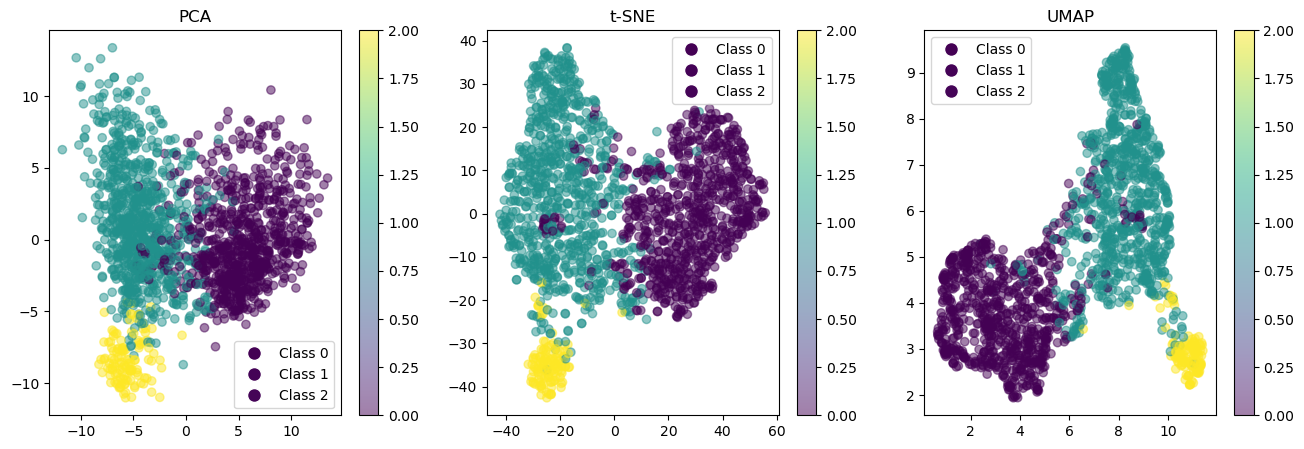

In [31]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from tensorflow.keras import models  # Import the models module

# Assuming your model is already trained and you have a dataset
# ...

# Function to get flattened feature vectors from the model
def get_flattened_features(model, dataset):
    features = []
    labels = []
    for image_batch, labels_batch in dataset:
        # Assuming the convolutional layers are up to the flatten layer
        intermediate_layer_model = models.Model(inputs=model.input,
                                                outputs=model.get_layer('flatten_5').output)  # Corrected layer name
        intermediate_output = intermediate_layer_model.predict(image_batch)
        features.extend(intermediate_output)
        labels.extend(labels_batch.numpy())
    return np.array(features), np.array(labels)

# Get flattened features and labels from the training dataset
train_features, train_labels = get_flattened_features(model_instance, train_ds)
print(train_features,train_labels)
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_features)

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP()
umap_result = umap_reducer.fit_transform(train_features)

# Plot the results
plt.figure(figsize=(16, 5))

# Plot PCA
plt.subplot(1, 3, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.title('PCA')
plt.colorbar(scatter)
legend_labels = np.unique(train_labels)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis.colors[i], markersize=10, label=f'Class {label}') for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles)

# Plot t-SNE
plt.subplot(1, 3, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE')
plt.colorbar(scatter)
legend_labels = np.unique(train_labels)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis.colors[i], markersize=10, label=f'Class {label}') for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles)

# Plot UMAP
plt.subplot(1, 3, 3)
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.title('UMAP')
plt.colorbar(scatter)
legend_labels = np.unique(train_labels)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis.colors[i], markersize=10, label=f'Class {label}') for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles)

plt.show()


### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 783ms/step
predicted label: Potato___Late_blight


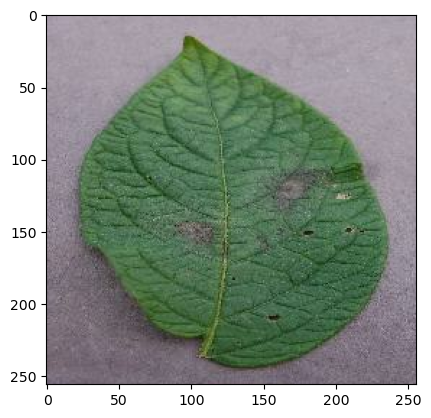

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_instance.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 55ms/step


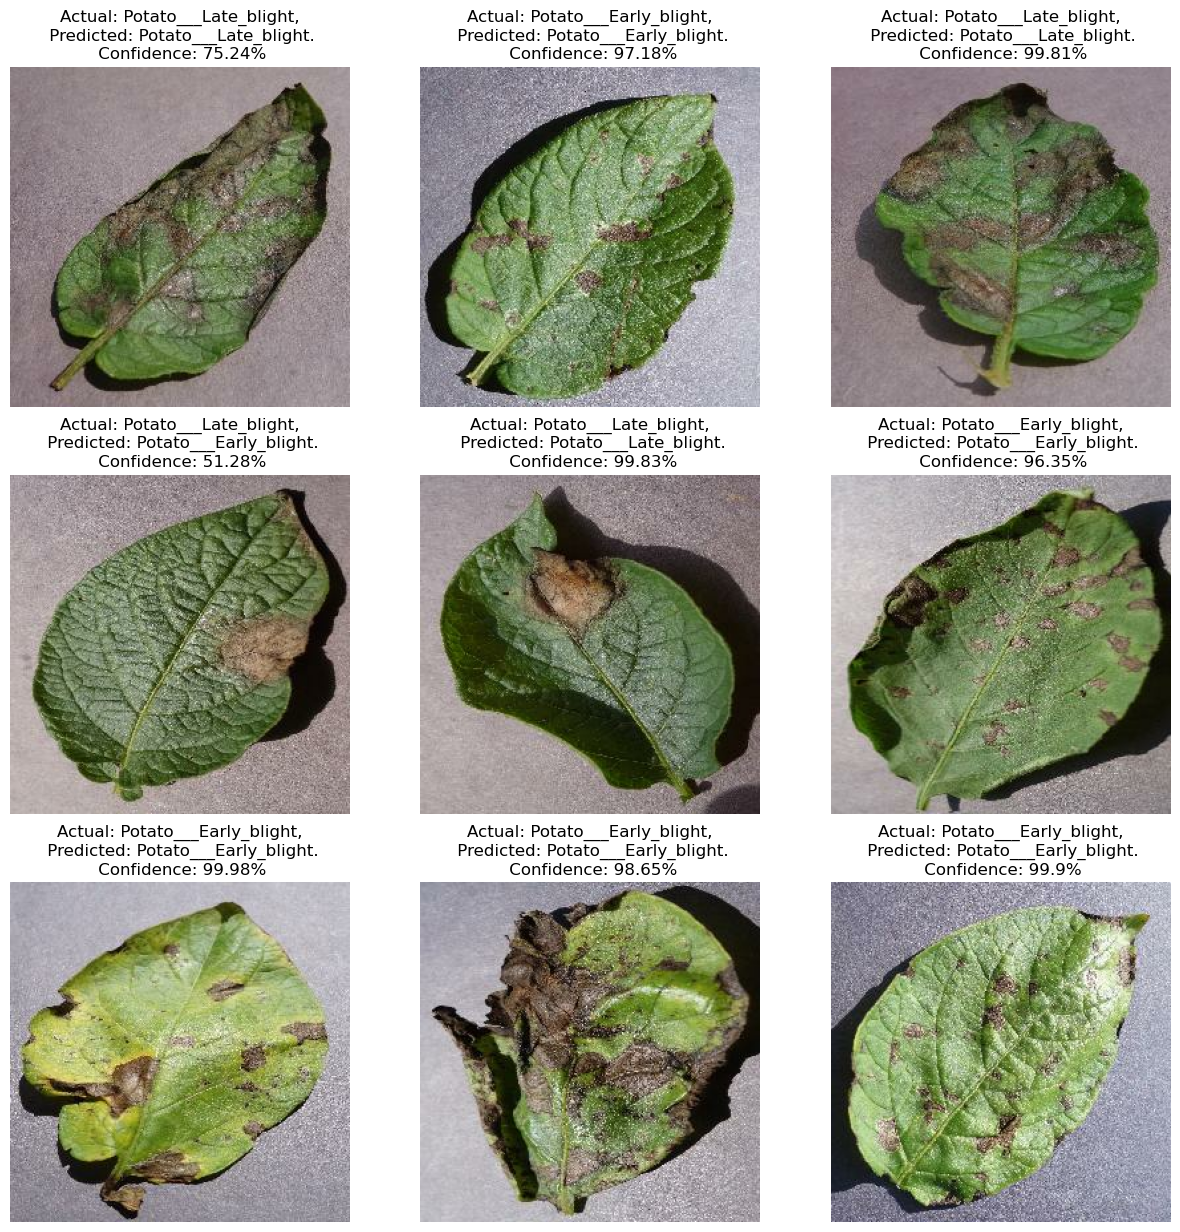

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_instance, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")